## Load libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json # import json for formatting data
import os # and os for saving
import boto3
import sagemaker
from sagemaker import get_execution_role

In [71]:
# Save as Dataframe the train file and keep only Store, Dept, Sales and use Date as Index
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)
train_df['Date'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in train_df['Date'].astype(str).values.tolist()]
train_df.index = train_df['Date']
train_df = train_df.drop(['Date', 'IsHoliday'], axis=1)

train_df.sort_values(["Store","Dept"], ascending = (False,False))

# take only one store for first try of training job
# train_df = train_df[train_df.Store == 1]

print(train_df.head())

            Store  Dept  Weekly_Sales
Date                                 
2010-02-05      1     1      24924.50
2010-02-12      1     1      46039.49
2010-02-19      1     1      41595.55
2010-02-26      1     1      19403.54
2010-03-05      1     1      21827.90


In [72]:
# Look at the Store list to see if there are missing numbers
print(train_df.Store.unique())
print(train_df.Store.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
45


In [74]:
# Look at the Dept list to see if there are missing numbers
print(train_df.Dept.unique())
print(train_df.Dept.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]
81


In [84]:
# Add columns to convert Store to a "Category" field appropriate for DeepAR
train_df['Cat_Store'] = train_df['Store'] - 1

# Add columns to convert Dept to a "Category" field appropriate for DeepAR
liste = range(81)
for i in liste:
    department = train_df.Dept.unique()[i]
    train_df.loc[train_df['Dept'] == department, 'Cat_Dept'] = int(i)  

print(train_df.head())

            Store  Dept  Weekly_Sales  Cat_Store  Cat_Dept
Date                                                      
2010-02-05      1     1      24924.50          0         0
2010-02-12      1     1      46039.49          0         0
2010-02-19      1     1      41595.55          0         0
2010-02-26      1     1      19403.54          0         0
2010-03-05      1     1      21827.90          0         0


In [86]:
# Verify Cat_Store
print(train_df.Cat_Store.unique())
print(train_df.Cat_Store.nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
45


In [85]:
# Verify Cat_Dept
print(train_df.Cat_Dept.unique())
print(train_df.Cat_Dept.nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
81


## Plot Sales Evolution

In [3]:
# Define a function to plot sales evolution depending of the store and department number
def sales_evolution(store_number, dept_number):
    example_store_dept_sales = train_df[(train_df.Store == store_number) & (train_df.Dept == dept_number)]['Weekly_Sales']
    plt.figure(figsize=(8,3))
    example_store_dept_sales.plot(title='Store {} Dpt {} Sales evolution'.format(store_number, dept_number), color='blue') 
    return plt.show()

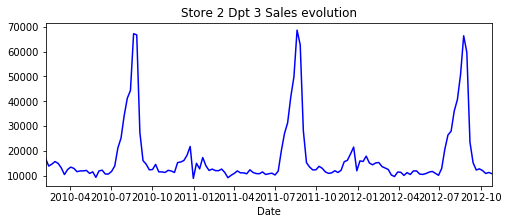

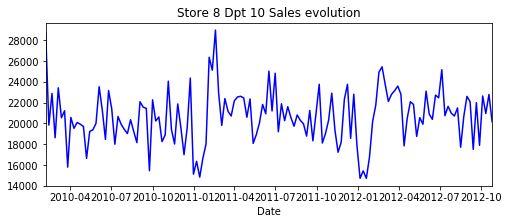

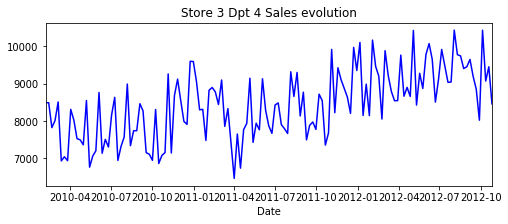

In [83]:
# Plot some examples
sales_evolution(2,3)
sales_evolution(8,10)
sales_evolution(3,4)

## Create and display complete time series

In [87]:
def make_time_series(df, years, freq='W-FRI'):
    '''Creates as many time series as they are stores x departments x complete years. 
      :param df: dataframe with train data. One 3 columns : Store, Dept, Weekly_Sales.
          This dataframe should also be indexed by a datetime.
      :param years: A list of years to make time series out of, ex. ['2010', '2011'].
      :param freq: The frequency of data recording (W-FRI = Weekly, starting on Friday)
      :return: A list of pd.Series(), time series data.
      '''
    
    # store time series
    time_series = []
    
    # create time series for each store and each department
    for store in df.Cat_Store.unique().tolist():
        for dept in df.Cat_Dept.unique().tolist():
            
            # create DataFrame with weekly_sales for the store and department studied
            sample_df = df[(df.Cat_Store == store) & (df.Cat_Dept == dept)]['Weekly_Sales']
                        
            # initialise start_idx
            start_idx = 0
            
            # create time series for each year in years
            for i in range(len(years)):

                # for each year 52 weeks (no year of 53 weeks in our dataset)
                year = years[i]
                end_idx = start_idx+52

                # create start and end datetimes
                t_start = year + '-02-05' # start with first date 
                t_end = str(int(year)+1) + '-01-28' # end friday one year later

                # get wanted sample_df data
                data = sample_df[start_idx:end_idx]

                # create time series for the year
                index = pd.date_range(start=t_start, end=t_end, freq=freq)
                Serie_df = pd.Series(data=data, index=index)
                
                # include info of the store and dept as last values to use as category in DeepAR
                Info_df = pd.Series(data=[int(store), int(dept)], index=['store','dept'])
                time_series.append(pd.concat([Serie_df, Info_df]))
                
                # start next year in loop
                start_idx = end_idx+1                
    
    # return list of time series
    return time_series

In [88]:
# Create yearly time series for our 2 complete years
full_years = ['2010', '2011']
freq='W-FRI' # weekly recordings

# make time series
time_series = make_time_series(train_df, full_years, freq=freq)

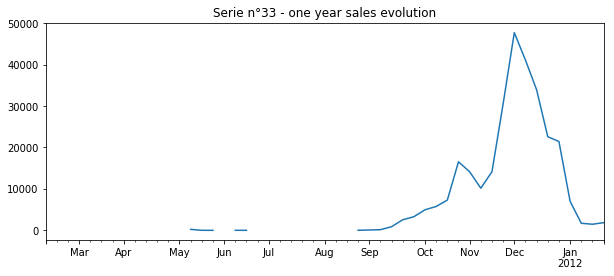

In [89]:
# display first time series
time_series_idx = 33

# plot time series except the last two values corresponding to store and department
plt.figure(figsize=(10,4))
time_series[time_series_idx][:-2].plot(title='Serie n°{} - one year sales evolution'.format(time_series_idx))
plt.show()

## Splitting in Time

In [90]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        
        # save store and departement number for the serie as Info
        Info_df = ts[-2:]
        
        # truncate "prediction_length" weeks + 2 corresponding to the store and departement number
        truncate = prediction_length + 2
        Train_Serie_df = ts[:-truncate]
        
        # save Train_Serie with its Info
        time_series_training.append(pd.concat([Train_Serie_df, Info_df]))
        
    return time_series_training

In [91]:
# set prediction length
prediction_length = 4 # 4 weeks ~ a month

time_series_training = create_training_series(time_series, prediction_length)

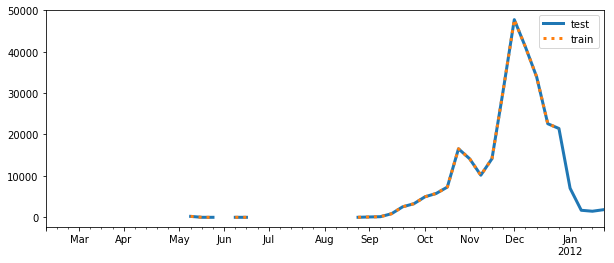

In [92]:
# display train/test time series
time_series_idx = 33

plt.figure(figsize=(10,4))
# test data is the whole time series
time_series[time_series_idx][:-2].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx][:-2].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON

In [93]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target and cat from the time series, ts
    target = list(ts[:-2])
    no_nan_target = pd.Series(target).fillna(0).tolist()
    
    json_obj = {"start": str(ts.index[0]), "target": no_nan_target, "cat": list(map(int, ts[-2:]))}
    return json_obj

In [94]:
# test out the code
ts = time_series[33]

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2011-02-11 00:00:00', 'target': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 227.24, 1.8, 0.35, 0.0, 1.0, 2.0, 0.0, 0.5, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 4.97, 83.64, 149.24, 868.86, 2540.81, 3279.04, 4959.46, 5758.87, 7304.78, 16545.45, 14133.85, 10170.41, 14159.67, 30543.19, 47731.67, 41114.36, 33932.27, 22602.34, 21444.65, 7018.32, 1700.85, 1468.65, 1842.47], 'cat': [0, 16]}


## Saving Data, Locally

In [95]:
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    print(filename + ' saved.')

In [96]:
# save this data to a local directory
data_dir = 'json_sales_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [97]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)

json_sales_data/train.json saved.
json_sales_data/test.json saved.


## Uploading data to S3

In [33]:
# session, role, bucket
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [34]:
# general prefix
prefix='deepar-weekly-sales'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [35]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/train/train.json
Test data is stored in: s3://sagemaker-eu-central-1-293973958717/deepar-weekly-sales/test/test.json


# Training a DeepAR Estimator

## Instantiate an Estimator

In [36]:
from sagemaker.amazon.amazon_estimator import get_image_uri

image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image

In [37]:
from sagemaker.estimator import Estimator

# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

## Setting Hyperparameters

In [38]:
freq='W'
context_length=4 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [39]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

## Training job

In [40]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-06-14 09:30:46 Starting - Starting the training job...
2020-06-14 09:30:48 Starting - Launching requested ML instances......
2020-06-14 09:31:51 Starting - Preparing the instances for training...
2020-06-14 09:32:34 Downloading - Downloading input data...
2020-06-14 09:33:05 Training - Downloading the training image..Arguments: train
[06/14/2020 09:33:24 INFO 140075443283776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/14/2020 09:33:24 I

In [ ]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)